# Makeup Transfer with CPM

This Colab demonstrates Makeup Transfer Application using **CPM** (Color-Pattern Makeup Transfer) model.

The model architecture is described in the paper "[Lipstick ain't enough: Beyond Color-Matching for In-the-Wild MakeUp Transfer](https://arxiv.org/abs/2104.01867)", in CVPR 2021.
Source code and datasets are publicly available on
[Github](github.com/VinAIResearch/CPM).

CPM is the a holistic makeup transfer model that can replicate **both colors and patterns** from a reference makeup style to another image.

In this Colab, we'll investigate each cases of transferring makeup:


*   Pattern + Color
*   Pattern Only
*   Color Only

**Please Create a COPY of this Notebook before you run the code**



### Requirements

In [1]:
# Install required libraries. This takes about **4-5 mins**.
%%time
!pip install torch==1.6.0 torchvision==0.7.0
!pip uninstall tensorflow -y
!pip install tensorflow-gpu==1.14
!pip install blend_modes
!pip install segmentation_models_pytorch

     |████████████████████████████████| 748.8 MB 18 kB/s 
     |████████████████████████████████| 5.9 MB 48.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.6.0 which is incompatible.
Found existing installation: tensorflow 2.5.0
Uninstalling tensorflow-2.5.0:
  Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 377.1 MB 9.1 kB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████

In [2]:
!git clone https://github.com/VinAIResearch/CPM

Cloning into 'CPM'...
remote: Enumerating objects: 353, done.
remote: Counting objects: 100% (353/353), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 353 (delta 180), reused 334 (delta 168), pack-reused 0
Receiving objects: 100% (353/353), 11.31 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (180/180), done.


### Mount Google Drive

In [3]:
# from google.colab import drive
# import os

# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive/"
# path = os.path.join(root_dir, 'CPM')
# print(path, os.listdir(path))

# os.chdir(path)

KeyboardInterrupt: ignored

In [4]:
%%shell
cd /content/CPM/
mkdir checkpoints
cd checkpoints
wget https://public.vinai.io/CPM_checkpoints/color.pth
wget https://public.vinai.io/CPM_checkpoints/pattern.pth

54.240.160.124, 54.240.160.3, 54.240.160.12, ...
Connecting to public.vinai.io (public.vinai.io)|54.240.160.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36974981 (35M) [binary/octet-stream]
Saving to: ‘color.pth’

color.pth           100%[===================>]  35.26M  23.0MB/s    in 1.5s    

2021-08-17 05:45:14 (23.0 MB/s) - ‘color.pth’ saved [36974981/36974981]

--2021-08-17 05:45:14--  https://public.vinai.io/CPM_checkpoints/pattern.pth
Resolving public.vinai.io (public.vinai.io)... 54.240.160.124, 54.240.160.3, 54.240.160.12, ...
Connecting to public.vinai.io (public.vinai.io)|54.240.160.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130433505 (124M) [binary/octet-stream]
Saving to: ‘pattern.pth’

pattern.pth         100%[===================>] 124.39M  34.1MB/s    in 4.1s    

2021-08-17 05:45:19 (30.2 MB/s) - ‘pattern.pth’ saved [130433505/130433505]



In [5]:
%cd /content/CPM/
!mkdir -p PRNet/net-data
%cd PRNet/net-data
!gdown --id 1UoE-XuW1SDLUjZmJPkIZ1MLxvQFgmTFH

/content/CPM
/content/CPM/PRNet/net-data
Downloading...
From: https://drive.google.com/uc?id=1UoE-XuW1SDLUjZmJPkIZ1MLxvQFgmTFH
To: /content/CPM/PRNet/net-data/256_256_resfcn256_weight.data-00000-of-00001
160MB [00:03, 47.3MB/s]


In [10]:
!gdown https://drive.google.com/uc?id=1l4HebC6VUeUaCFD-EPCY4aPveKJaSClH
!mkdir -p /content/data/images/initial
!unzip input.zip -d /content/data/images/initial/

Downloading...
From: https://drive.google.com/uc?id=1l4HebC6VUeUaCFD-EPCY4aPveKJaSClH
To: /content/CPM/PRNet/net-data/input.zip
2.36MB [00:00, 75.7MB/s]
Archive:  input.zip
  inflating: /content/data/images/initial/2_orig.png  
  inflating: /content/data/images/initial/0_orig.png  


In [11]:
!gdown --id 1mHNSSeb2eXXU96lmpy8hFAnluRabOopU
!mkdir -p /content/data/images/styles/
!unzip styles.zip -d /content/data/images/styles/

Downloading...
From: https://drive.google.com/uc?id=1mHNSSeb2eXXU96lmpy8hFAnluRabOopU
To: /content/CPM/PRNet/net-data/styles.zip
100% 236k/236k [00:00<00:00, 34.1MB/s]
Archive:  styles.zip
  inflating: /content/data/images/styles/style-7.jpg  
  inflating: /content/data/images/styles/style-8.jpg  
  inflating: /content/data/images/styles/style-9.jpg  
  inflating: /content/data/images/styles/style-10.jpeg  


# Usage

Input:
- Original Image (Non-makeup) (left)
- Style (right)

We'll go though 3 type of makeup transfer:

- Pattern + Color
- Color Only
- Pattern Only

In [6]:
%cd CPM

[Errno 2] No such file or directory: 'CPM'
/content/CPM/PRNet/net-data


In [26]:
style_image = '/content/CPM/imgs/style-4.png' 
content_image = '/content/CPM/imgs//0_orig.png'

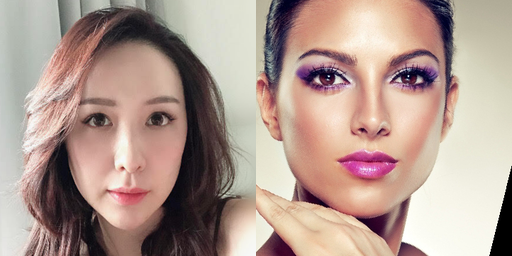

In [27]:
# Check input images
from PIL import Image
import numpy as np

original = np.array(Image.open(content_image).resize((256, 256), Image.ANTIALIAS))
style = np.array(Image.open(style_image).resize((256, 256), Image.ANTIALIAS))

Image.fromarray(np.concatenate([original, style], axis=1))

### Pattern + Color

In [ ]:
%cd /content/CPM/

In [20]:
path ="/content/CPM/"

In [34]:
# Pattern + Color: Image will be saved in 'result.png'
%cd /content/CPM/
!python -W ignore main.py --style ./imgs/style-5.png --input ./imgs/0_orig.png

/content/CPM


           ⊱ ──────ஓ๑♡๑ஓ ────── ⊰
🎵 hhey, arguments are here if you need to check 🎵
checkpoint_pattern:      ./checkpoints/pattern.pth
checkpoint_color:        ./checkpoints/color.pth
         device:                           cuda
            prn:                           True
     color_only:                          False
   pattern_only:                          False
          input:              ./imgs/0_orig.png
          style:             ./imgs/style-5.png
          alpha:                            0.5
        savedir:                              .

2021-08-17 06:06:21.226754: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-08-17 06:06:21.231897: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2021-08-17 06:06:21.232186: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560dea5e99c0 executing computations

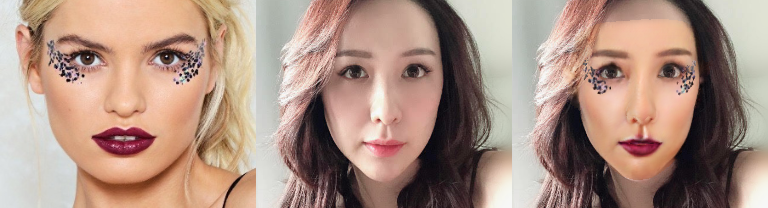

In [35]:
Image.open(os.path.join(path, 'result.png'))

### Color Only

In [32]:
# Color Only: Image will be saved in 'result.png'
%cd /content/CPM/
!python -W ignore main.py --style ./imgs/style-5.png --input ./imgs/non-makeup.png --color_only --alpha 0.8

/content/CPM


           ⊱ ──────ஓ๑♡๑ஓ ────── ⊰
🎵 hhey, arguments are here if you need to check 🎵
checkpoint_pattern:      ./checkpoints/pattern.pth
checkpoint_color:        ./checkpoints/color.pth
         device:                           cuda
            prn:                           True
     color_only:                           True
   pattern_only:                          False
          input:          ./imgs/non-makeup.png
          style:             ./imgs/style-5.png
          alpha:                            0.8
        savedir:                              .

2021-08-17 06:04:21.932446: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-08-17 06:04:21.936947: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2021-08-17 06:04:21.937220: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559fedc50840 executing computations

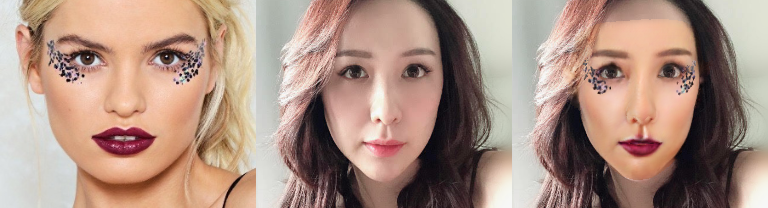

In [36]:
Image.open(os.path.join(path, 'result.png'))

### Pattern Only

In [ ]:
# Pattern Only: Image will be saved in 'result.png'
%cd /content/CPM/
!python -W ignore main.py --style ./imgs/style-1.png --input ./imgs/non-makeup.png --pattern_only 

In [ ]:
Image.open(os.path.join(path, 'result.png'))

### Color- Transfer Controllable

You can control the obviousness of color-transfer by `alpha` (0-1)

In [ ]:
# Color Only: Degree: 0.7
os.chdir(path)
!python -W ignore main.py --style ./imgs/style-3.png --input ./imgs/non-makeup.png --color_only --alpha 0.7

In [ ]:
Image.open(os.path.join(path, 'result.png'))

In [ ]:
# Color Only: Degree: 0.3
os.chdir(path)
!python -W ignore main.py --style ./imgs/style-3.png --input ./imgs/non-makeup.png --color_only --alpha 0.3

In [ ]:
Image.open(os.path.join(path, 'result.png'))

**The End**